In [1]:


import sys 
import matplotlib.pyplot as plt
import numpy as np 
from numpy import sin, cos
from math import atan2
from time import sleep

sys.path.append("../")


from pydrake.common.value import Value
from pydrake.geometry import StartMeshcat, MeshcatVisualizer
from pydrake.systems.framework import DiagramBuilder, LeafSystem, BasicVector
from pydrake.multibody.math import SpatialForce
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph, ExternallyAppliedSpatialForce, ExternallyAppliedSpatialForceMultiplexer, AddMultibodyPlant
from pydrake.multibody.parsing import Parser
from pydrake.systems.analysis import Simulator
from pydrake.math import inv
from pydrake.systems.controllers import PidController

from pydrake.all import AbstractValue, LogVectorOutput,  JacobianWrtVariable


from src.plant.PPR import PlanarPPR
from src.mapping.PPR_theta import PlanarPPR_theta

from src.controller.CartesianContrellerEE import CartesianController
from src.utils import save_diagram_svg, visualize


Simulation of a planar PPR without input decoupling, pure dynamic system 

In [3]:
def simulate_PPR_pure_dyn_in_q(sim_time, desired_state=np.array([0.5, 0.5, 0, 0])):


    builder = DiagramBuilder()
    plant = builder.AddSystem(PlanarPPR())
    controller = builder.AddSystem(CartesianController())


    builder.Connect(plant.GetOutputPort("EE_state"), controller.GetInputPort('actual_state'))
    builder.Connect(controller.GetOutputPort("F"), plant.GetInputPort("F"))



    logger_ee = LogVectorOutput(plant.GetOutputPort("EE_state"), builder)
    logger_qVect = LogVectorOutput(plant.GetOutputPort('state'), builder)
    logger_controller = LogVectorOutput(controller.GetOutputPort("F"), builder)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    plant_context = plant.GetMyContextFromRoot(context)
    controller_context = controller.GetMyMutableContextFromRoot(context)

    plant_context.SetContinuousState(np.zeros(6))
    controller.GetInputPort("desired_state").FixValue(controller_context, desired_state)
    
    sim = Simulator(diagram, context)
    sim.AdvanceTo(sim_time)

    loggers = {
        "log_ee" : logger_ee, 
        "log_qVect" : logger_qVect, 
        "log_F": logger_controller
    }
    
    return context, diagram, loggers

sim_time=30
context, diagram, loggers = simulate_PPR_pure_dyn_in_q(sim_time)

In [4]:


log_ee = loggers['log_ee'].FindLog(context)
log_qVect = loggers['log_qVect'].FindLog(context)
log_F = loggers['log_F'].FindLog(context)

times = log_ee.sample_times()

q1, q2, q3, dq1, dq2, dq3 = log_qVect.data()
fx, fy = log_F.data()
x_ee, y_ee, dx_ee, dy_ee = log_ee.data()


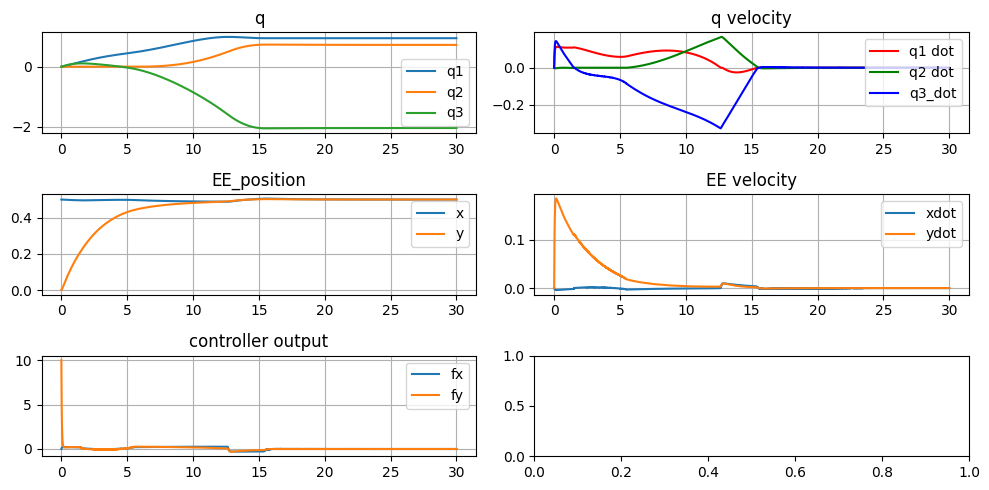

In [5]:


fig, axis = plt.subplots(3, 2, figsize=(10, 5))

axis[0, 0].plot(times, q1, label='q1')
axis[0, 0].plot(times, q2, label='q2')
axis[0, 0].plot(times, q3, label='q3') 
axis[0, 0].set_title('q')
axis[0, 0].grid()
axis[0, 0].legend()

axis[0, 1].plot(times, dq1, color='red', label='q1 dot')
axis[0, 1].plot(times, dq2, color='green', label='q2 dot')
axis[0, 1].plot(times, dq3, color='blue', label='q3_dot')
axis[0, 1].set_title("q velocity")
axis[0, 1].grid()
axis[0, 1].legend(loc='upper right')



axis[1, 0].plot(times, x_ee, label='x')
axis[1, 0].plot(times, y_ee, label='y')
axis[1, 0].set_title("EE_position")
axis[1, 0].legend()
axis[1, 0].grid()

axis[1, 1].plot(times, dx_ee, label='xdot')
axis[1, 1].plot(times, dy_ee, label='ydot')
axis[1, 1].set_title("EE velocity")
axis[1, 1].legend()
axis[1, 1].grid()

axis[2, 0].plot(times, fx, label="fx")
axis[2, 0].plot(times, fy, label='fy')
axis[2, 0].set_title("controller output")
axis[2, 0].legend()
axis[2, 0].grid()

plt.tight_layout()


In [2]:
""" load new system with the plant, the visualizer and force for each value the joint position """
meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7000


In [ ]:
publish_rate=round(sim_time/times.shape[0], 3) 
visualize(meshcat=meshcat, 
          robot_sdf_path='../sdf_model/PPR_planar.sdf', 
          q_state_vect=log_qVect.data().T,
          rate=publish_rate)


In [4]:
def plot_log(log_plant, log_controller):

    plt.figure()
    times = log_plant.sample_times()

    theta1, theta2, theta3, d_theta1, d_theta2, d_theta3= log_plant.data()
    fx, fy = log_controller.data()[0], log_controller.data()[1]

    q1, q2 = [], []
    for i in range(len(theta1)):
        q1_i = theta2 - 1*sin(theta3)
        q2_i = theta1 - 1*cos(theta3)
        q1.append(q1_i)
        q2.append(q2_i)

    fig, axis = plt.subplots(2, 2)

    axis[0, 0].plot(times, theta1, label='theta1 = x')
    axis[0, 0].plot(times, theta2, label='theta2 = y')
    axis[0, 0].plot(times, theta3, label='theta3 = q3')
    axis[0, 0].set_title('theta')
    axis[0, 0].grid()
    axis[0, 0].legend()

    axis[0, 1].plot(times, d_theta1, color='red', label='d_theta1 = x_dot')
    axis[0, 1].plot(times, d_theta2, color='green', label='d_theta2 = y_dot')
    axis[0, 1].plot(times, d_theta3, color='blue', label='d_theta3 = q3_dot')
    axis[0, 1].set_title("theta velocity")
    axis[0, 1].grid()
    axis[0, 1].legend()
    
    
    axis[1, 0].plot(times, fx, label="fx")
    axis[1, 0].plot(times, fy, label='fy')
    axis[1, 0].set_title("controller output")
    axis[1, 0].legend()
    axis[1, 0].grid()


    q1, q2 = [], []
    for i in range(len(theta1)):
        q1_i = theta2[i] - 1*sin(theta3[i])
        q2_i = theta1[i] - 1*cos(theta3[i])
        q1.append(q1_i)
        q2.append(q2_i)


    axis[1, 1].plot(times, q1, label='q1')
    axis[1, 1].plot(times, q2, label='q2')
    axis[1, 1].set_title('q variable')
    axis[1, 1].grid()
    axis[1, 1].legend()

    plt.tight_layout()
    plt.show()



In [12]:
def simulate_pure_dyn_in_theta(sim_time, desired_posit):
    builder = DiagramBuilder()

    PPR = builder.AddSystem(PlanarPPR_theta())

    controller = builder.AddSystem(CartesianController()
    )
    #controller = builder.AddSystem(PidController(kp=[3, 3], ki=[0.5, 0.5], kd=[200., 200.]))


    builder.Connect(PPR.GetOutputPort("EE_state"), controller.GetInputPort('actual_state'))
    builder.Connect(controller.get_output_port(), PPR.get_input_port())


    logger_PPR = LogVectorOutput(PPR.GetOutputPort("state"), builder)

    logger_controller = LogVectorOutput(controller.GetOutputPort("F"), builder) # handMade pd
    #logger_controller = LogVectorOutput(controller.GetOutputPort("control"), builder)  # library pId

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    PPR_context = PPR.GetMyContextFromRoot(context)
    controller_context = controller.GetMyMutableContextFromRoot(context)

    PPR_context.SetContinuousState(np.array([0, 0, 0, 0, 0, 0]))
    controller.GetInputPort('desired_state').FixValue(controller_context, desired_posit)

    sim = Simulator(diagram, context)
    sim.AdvanceTo(sim_time)

    loggers = {
        "plant":logger_PPR, 
        "controller":logger_controller
    }
    return diagram, context, loggers

In [10]:
log = loggers['plant'].FindLog(context)
theta1, theta2, d_theta1, d_theta2 = log.data()
times = log.sample_times()

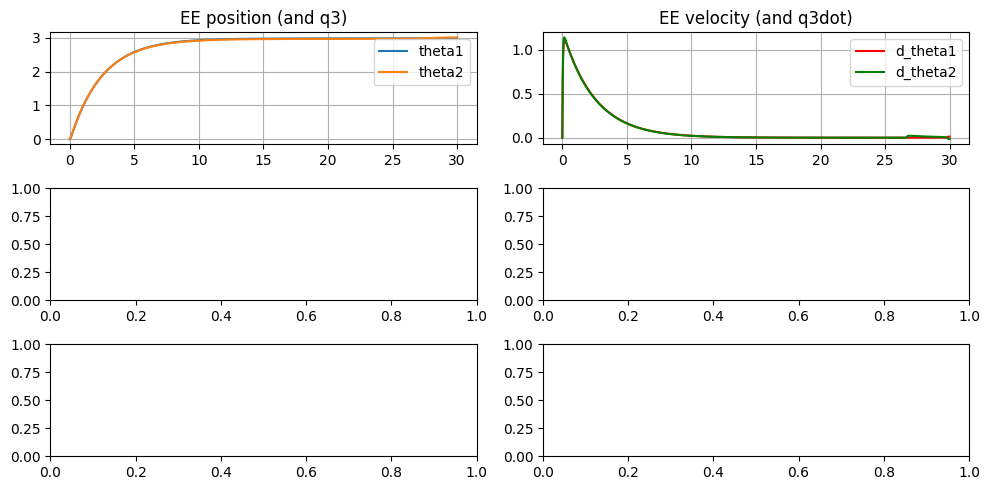

In [11]:


fig, axis = plt.subplots(3, 2, figsize=(10, 5))

axis[0, 0].plot(times, theta1, label='theta1')
axis[0, 0].plot(times, theta2, label='theta2')
axis[0, 0].set_title('EE position (and q3)')
axis[0, 0].grid()
axis[0, 0].legend()

axis[0, 1].plot(times, d_theta1, color='red', label='d_theta1')
axis[0, 1].plot(times, d_theta2, color='green', label='d_theta2')
axis[0, 1].set_title("EE velocity (and q3dot)")
axis[0, 1].grid()
axis[0, 1].legend()

"""axis[2, 0].plot(times, fx, label="fx")
axis[2, 0].plot(times, fy, label='fy')
axis[2, 0].set_title("controller output")
axis[2, 0].legend()
axis[2, 0].grid()"""


plt.tight_layout()
plt.show()

